# Quantify nutrient loading inputs
`create_scenario_pnt_wq_v3_090622.py` is "Python script for creating the river and point source scenario loading `ssm_pnt_wq.dat` input files"

In [1]:
import os
import yaml
import numpy as np
from io import StringIO
import pandas as pd
import pathlib
import time
from datetime import date
import matplotlib.pyplot as plt
import matplotlib as mpl

### Define file paths

In [2]:
# Get paths from configuration file
case = 'whidbey'
with open(f'../../etc/SSM_config_{case}.yaml', 'r') as file:
    ssm = yaml.safe_load(file)
# loading_dir = pathlib.Path("/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel/run_scenarios/input_setting")
runs = [*ssm['paths']['nutrient_loading_inputs']]
loading_files = {}
for run in runs:
    print(ssm['paths']['nutrient_loading_inputs'][run])#loading_files[run] = loading_dir/f"ssm_pnt_wq_{run}.dat"

/mmfs1/gscratch/ssmc/USRS/PSI/Sukyong/kingcounty/WQM/WQM/hotstart/inputs/ssm_pnt_wq.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Sukyong/kingcounty/WQM_REF/WQM_REF/hotstart/inputs/ssm_pnt_wq.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Sukyong/kingcounty/3b/inputs/ssm_pnt_wq.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Sukyong/kingcounty/3e/inputs/ssm_pnt_wq.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Sukyong/kingcounty/3f/inputs/ssm_pnt_wq.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Sukyong/kingcounty/3g/inputs/ssm_pnt_wq.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Sukyong/kingcounty/3h/inputs/ssm_pnt_wq.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Sukyong/kingcounty/3i/inputs/ssm_pnt_wq.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel/3j/hotstart/inputs/ssm_pnt_wq.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel/3k/hotstart/inputs/ssm_pnt_wq.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Sukyong/kingcounty/3c/inputs/ssm_pnt_wq.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel/3l/hotstart

In [3]:
ssm['paths']['nutrient_loading_inputs']['3j']='/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel/run_scenarios/input_setting/ssm_pnt_wq_3j.dat'
ssm['paths']['nutrient_loading_inputs']['3k']='/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel/run_scenarios/input_setting/ssm_pnt_wq_3k.dat'
runs = [*ssm['paths']['nutrient_loading_inputs']]
runs

['wqm_baseline',
 'wqm_reference',
 '3b',
 '3e',
 '3f',
 '3g',
 '3h',
 '3i',
 '3j',
 '3k',
 '3c',
 '3l',
 '3m']

### Create list of source names

In [4]:
in_dir = pathlib.Path('/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel-spreadsheets')
source_locations = pd.read_excel(in_dir/'ssm_pnt_wq_station_info.xlsx',index_col='Unnamed: 0')
source_names=source_locations.index.tolist()

### Load loading inputs
This code comes from Ben Roberts.  I got the same results with my method but like Ben's better because it covers all variables. See [ssm_read_pnt_wq.ipynb](https://github.com/bedaro/ssm-analysis/blob/main/input_files/ssm_read_pnt_wq.ipynb)

From Ben Roberts:
```
The discharges are in m3/s, and cover a 24-hour period (technically the model linearly interpolates between them but that doesn't change the final result). The units for most constituents are mg/l and for the nitrogen constituents it's mg-N/l == g-N/m^3.

So when I load the NetCDF into a dataset named 'ds' and do this:
(ds['discharge'][:,0] * (ds['nh4'][:,0] + ds['no32'][:,0]) * 24 * 3600).sum()
```

In [5]:
inputs = {}
for run in runs:
    with open(ssm['paths']['nutrient_loading_inputs'][run]) as f:
        # The parsing logic here is is derived from the linkage instructions for the
        # model and direct examination of the source code

        # The first line does not contain important information and is treated only like
        # a filetype magic
        next(f)

        # The total number of discharge nodes
        num_qs = int(next(f))
        # All the node numbers with discharges
        #nodes = np.loadtxt([next(f) for l in range(num_qs)], comments='!', dtype=int)
        node_raw = StringIO('\n'.join([next(f) for l in range(num_qs)]))
        node_df = pd.read_csv(node_raw, sep='\s+!\s+', names=('Node','Comment'),
                              dtype={'Node':np.int64,'Comment':object}, engine='python')
        node_df.set_index('Node', inplace=True)
        nodes = node_df.index.to_numpy()
        # Depth distribution fractions into each node. Skipping the first (node count) column
        vqdist = np.loadtxt([next(f) for l in range(num_qs)])[:,1:]

        num_times = int(next(f))

        # Initialize storage arrays
        times = np.zeros(num_times)
        qs = np.zeros((num_times, num_qs))
        # State variables in the order they are present in the file. These are also going
        # to be the NetCDF variable names
        statevars = ('discharge', 'temp', 'salt', 'tss',  'alg1', 'alg2', 'alg3', 'zoo1',
                                  'zoo2', 'ldoc', 'rdoc', 'lpoc', 'rpoc', 'nh4',  'no32',
                                  'urea', 'ldon', 'rdon', 'lpon', 'rpon', 'po4',  'ldop',
                                  'rdop', 'lpop', 'rpop', 'pip',  'cod',  'doxg', 'psi',
                                  'dsi',  'alg1p','alg2p','alg3p','dic',  'talk')
        inputs[run] = {}
        for v in statevars:
            inputs[run][v] = np.zeros((num_times, num_qs))

        for t in range(num_times):
            times[t] = float(next(f))
            for v in statevars:
                inputs[run][v][t,:] = np.loadtxt([next(f)])

# Sum all loading over year  
Sum of loading over year for Agate East, node 15634, is 4926 kg/year

In [6]:
total_nitrogen={}
total_annual_nitrogen={}
loading={}
for run in runs:
    loading[run] = (inputs[run]['discharge'] * (inputs[run]['nh4'] + inputs[run]['no32']) * 24 * 3600)/1000 #m3/s*mg/l -> kg/day
    total_nitrogen[run]=loading[run][1:].sum(axis=0) # annual loading over 365 days (g/year)
    total_annual_nitrogen[run] = total_nitrogen[run].sum() # g/year -> kg/year

In [7]:
total_annual_nitrogen

{'wqm_baseline': 51622442.40922475,
 'wqm_reference': 34106397.85531079,
 '3b': 50413880.300147474,
 '3e': 51584662.39727892,
 '3f': 51185291.76742399,
 '3g': 50888675.36812523,
 '3h': 51259091.88759467,
 '3i': 51252025.88975531,
 '3j': 51622433.58836363,
 '3k': 51620150.76357515,
 '3c': 45247678.285975546,
 '3l': 50614905.15356122,
 '3m': 57997202.271402195}

In [8]:
total_annual_nitrogen

{'wqm_baseline': 51622442.40922475,
 'wqm_reference': 34106397.85531079,
 '3b': 50413880.300147474,
 '3e': 51584662.39727892,
 '3f': 51185291.76742399,
 '3g': 50888675.36812523,
 '3h': 51259091.88759467,
 '3i': 51252025.88975531,
 '3j': 51622433.58836363,
 '3k': 51620150.76357515,
 '3c': 45247678.285975546,
 '3l': 50614905.15356122,
 '3m': 57997202.271402195}

## Create dataframes to write to excel

In [9]:
total_nitrogen_df = pd.DataFrame(total_nitrogen, index=source_names) # scenario total
total_annual_nitrogen_df = pd.DataFrame(total_annual_nitrogen,index=['total loading']) # source total (by scenario)

# Create excel spreadsheet of total nitrogen loading per run

In [10]:
# make README 
this_file = '=HYPERLINK("https://github.com/RachaelDMueller/SalishSeaModel-analysis/blob/main/notebooks/reports/create_loading_spreadsheets_whidbey.ipynb")'
run_description = '=HYPERLINK("https://github.com/RachaelDMueller/KingCounty-Rachael/blob/main/docs/supporting/KingCounty_Model_Runs.xlsx","KingCounty_Model_Runs.xlsx")'
units='kg/year'
created_by = 'Rachael D. Mueller'
created_at = 'Puget Sound Institute'
created_from = 'Model results produced by Su Kyong Yun (PNNL) and Rachael Mueller (PSI)'
created_on = date.today().strftime("%B %d, %Y")
contact = 'Rachael D Mueller (rdmseas@uw.edu)'
header = {
    ' ':[created_by, created_at, created_on, this_file, 
        contact, created_from, 
        run_description, units]
}
header_df = pd.DataFrame(header, index=[
    'Created by',
    'Created at',                           
    'Created on',
    'Created with',
    'Contacts',
    'Modeling by',
    'Model Run Overview',
    'Units'])

# Save to output to 
excel_output_path = pathlib.Path(ssm['paths']['processed_output'])/case/'spreadsheets'
with pd.ExcelWriter(excel_output_path/f'{case}_total_nitrogen_loading.xlsx', mode='w') as writer:
    total_annual_nitrogen_df.to_excel(writer, sheet_name='scenario_total')
    total_nitrogen_df.to_excel(writer, sheet_name='source_total')
    header_df.to_excel(writer, sheet_name='README')

In [11]:
excel_output_path/f'{case}_total_nitrogen_loading.xlsx'

PosixPath('/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/whidbey/spreadsheets/whidbey_total_nitrogen_loading.xlsx')

# Plot normalized loading values and regressions

In [12]:
river_runs = ssm['run_information']['Whidbey_rivers']
wwtp_runs = ssm['run_information']['Whidbey_WWTPs']
#remove reference b/c we don't calculate volume days noncompliance for reference case
# river_runs.pop('wqm_reference')
# wwtp_runs.pop('wqm_reference')
# wwtp_runs.pop('Wtp7')

In [13]:
[*wwtp_runs]

['wqm_baseline',
 'wqm_reference',
 '3b',
 '3e',
 '3f',
 '3g',
 '3h',
 '3i',
 '3j',
 '3k']

## Create lists of runs for coloring plot markers

In [14]:
runs_renamed={}
runs_renamed['rivers']=[ssm['run_information']['run_tag']['whidbey'][key] for key in [*river_runs]]
runs_renamed['wwtp']=[ssm['run_information']['run_tag']['whidbey'][key] for key in [*wwtp_runs]]
runs_renamed['base']=['2014 Conditions']
# Wtp7 needs to be re-done.   Removing from graphic
runs_renamed['wwtp'].remove('Wtp7')
runs_renamed['wwtp'].remove('Reference')
runs_renamed['rivers'].remove('Reference')
runs_renamed['wwtp']

['2014 Conditions', 'Wtp1', 'Wtp2', 'Wtp3', 'Wtp4', 'Wtp5', 'Wtp6', 'Wtp8']

In [15]:
runs_renamed['rivers']

['2014 Conditions', 'Wr1', 'Wr2', 'Wr3']

## Create normalized volume days values

In [16]:
region = 'ALL_REGIONS' # 'Whidbey' # 

whidbey_nc = pd.read_excel('/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/whidbey/spreadsheets/whidbey_wc_noncompliant_m0p25.xlsx',
                           sheet_name='Volume_Days',
                          index_col="Unnamed: 0")
whidbey_vd_norm={}
for run in [*whidbey_nc]:
    whidbey_vd_norm[run] = whidbey_nc[run][region]/whidbey_nc['2014 Conditions'][region]
whidbey_vd_norm

{'2014 Conditions': 1.0,
 'Wtp1': 0.6715025960385523,
 'Wtp2': 0.9901701010059237,
 'Wtp3': 0.8482532387273433,
 'Wtp4': 0.786135191181453,
 'Wtp5': 0.862071811635803,
 'Wtp6': 0.9043317644073674,
 'Wtp7': 0.9368489027903925,
 'Wtp8': 0.9949548096393074,
 'Wr1': 0.028883478058174487,
 'Wr2': 0.7852548079536077,
 'Wr3': 5.149649311438766}

## Create normalized loading values

In [17]:
normalized_loading = {}
for run in [*total_annual_nitrogen]:
    # use mapping from Hyak to report names (ssm['run_information']['run_tag']['whidbey']) 
    # to get key-values with report names
    normalized_loading[ssm['run_information']['run_tag']['whidbey'][run]] = total_annual_nitrogen[run]/total_annual_nitrogen['wqm_baseline'] 
normalized_loading.pop('Wtp7')
normalized_loading


{'2014 Conditions': 1.0,
 'Reference': 0.6606893487320952,
 'Wtp1': 0.9765884361011693,
 'Wtp2': 0.9992681475307515,
 'Wtp3': 0.991531771427331,
 'Wtp4': 0.9857858906542477,
 'Wtp5': 0.9929613845321439,
 'Wtp6': 0.9928245061221038,
 'Wtp8': 0.9999556075702225,
 'Wr1': 0.8765117684143117,
 'Wr2': 0.9804825729151574,
 'Wr3': 1.1234881490426787}

In [18]:
N_plot={}
vd_plot={}
for group in ['rivers','wwtp','base']:
    N_plot[group] = np.array([normalized_loading[run] for run in runs_renamed[group]])
    vd_plot[group] = np.array([whidbey_vd_norm[run] for run in runs_renamed[group]])

In [19]:
N_plot['rivers']

array([1.        , 0.87651177, 0.98048257, 1.12348815])

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


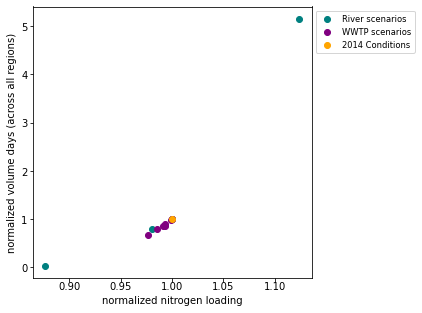

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5),
       gridspec_kw={
           'width_ratios': [1],
           'height_ratios': [1],
       'wspace': 0.25,
       'hspace': 0.15})
ax.scatter(N_plot['rivers'],vd_plot['rivers'],color='teal',label='River scenarios')
ax.scatter(N_plot['wwtp'],vd_plot['wwtp'],color='purple',label='WWTP scenarios')
ax.scatter(N_plot['base'],vd_plot['base'],color='orange',label='2014 Conditions')
# plt.plot(np.unique(N_plot[rivers_2014]), np.poly1d(np.polyfit(N_plot[rivers_2014], vd_plot[rivers_2014], 1))(np.unique(N_plot[rivers_2014])), color='teal')
# plt.plot(np.unique(N_plot[wwtp_2014]), np.poly1d(np.polyfit(N_plot[wwtp_2014], vd_plot[wwtp_2014], 1))(np.unique(N_plot[wwtp_2014])), color='purple')
# x = np.array([.9,1,1.1])
#plt.plot(x, 14.06516795*x + -13.07638237,'k')
# fig.text(.15,0.825,f"y={w_poly['rivers'][1]:2.1f}x+{w_poly['rivers'][0]:2.1f} (RMSE: {rmse['rivers']:.2f})",color='teal')
# fig.text(.15,0.775,f"y={w_poly['wwtp'][1]:2.1f}x+{w_poly['wwtp'][0]:2.1f} (RMSE: {rmse['wwtp']:.2f})",color='purple')
ax.legend(bbox_to_anchor=(1,1),loc='upper left')
ax.set_xlabel('normalized nitrogen loading')
if region == "ALL_REGIONS":
    ax.set_ylabel(f'normalized volume days (across all regions)')
else:
    ax.set_ylabel(f'normalized volume days ({region})')

## Calculate line fits and RMSE

In [21]:
w_poly={}
rmse={}
xvalues={}
yvalues={}

# fit_values = w_poly['rivers'][2]*N_plot[rivers_2014]**2+w_poly['rivers'][1]*N_plot[rivers_2014]+w_poly['rivers'][0]                                                          
# rmse['rivers']=np.sqrt(np.sum((vd_plot[rivers_2014]-fit_values)**2)/len(vd_plot[rivers_2014]))

# line for WWTPs
w_poly['wwtp']=np.poly1d(np.polyfit(N_plot['wwtp'], vd_plot['wwtp'], 1))
fit_values = w_poly['wwtp'][1]*N_plot['wwtp']+w_poly['wwtp'][0]                                                          
rmse['wwtp']=np.sqrt(np.sum((vd_plot['wwtp']-fit_values)**2)/len(vd_plot['wwtp']))
print('rmse wwtps: ', rmse['wwtp'])

# polynnomial for rivers
w_poly['rivers']=np.poly1d(np.polyfit(N_plot['rivers'], vd_plot['rivers'], 3))
fit_values = w_poly['rivers'][3]*N_plot['rivers']**3+w_poly['rivers'][2]*N_plot['rivers']**2+w_poly['rivers'][1]*N_plot['rivers']+w_poly['rivers'][0] 
rmse['rivers']=np.sqrt(np.sum((vd_plot['rivers']-fit_values)**2)/len(vd_plot['rivers']))
xvalues['rivers']=np.arange(N_plot['rivers'][0],N_plot['rivers'][-2]+.01, 0.01)
yvalues['rivers']=w_poly['rivers'][3]*xvalues['rivers']**3+w_poly['rivers'][2]*xvalues['rivers']**2+w_poly['rivers'][1]*xvalues['rivers']+w_poly['rivers'][0] 
print('rmse rivers: ', rmse['rivers'])

rmse wwtps:  0.01559898112311044
rmse rivers:  4.2773415571638817e-14


## Create 2-panel graphic

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


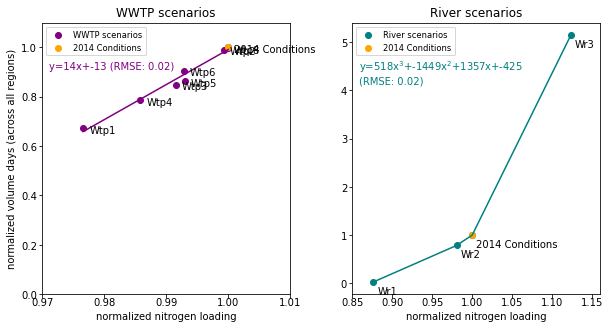

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5),
       gridspec_kw={
           'width_ratios': [1,1],
           'height_ratios': [1],
       'wspace': 0.25,
       'hspace': 0.15})
# plot up wwtp scenarios 
ax[0].scatter(N_plot['wwtp'],vd_plot['wwtp'],color='purple',label='WWTP scenarios')
ax[0].scatter(N_plot['base'],vd_plot['base'],color='orange',label='2014 Conditions')
ax[0].plot(np.unique(N_plot['wwtp']), np.poly1d(np.polyfit(N_plot['wwtp'], vd_plot['wwtp'], 1))(np.unique(N_plot['wwtp'])), color='purple')
# add text for line fit
fig.text(.135,0.75,f"y={w_poly['wwtp'][1]:2.0f}x+{w_poly['wwtp'][0]:2.0f} (RMSE: {rmse['wwtp']:.2f})",color='purple')
# add run labels to graphic
[ax[0].text(x=N_plot['wwtp'][idx]+.001, y=vd_plot['wwtp'][idx]-.02, s=run_name) for idx,run_name in enumerate(runs_renamed['wwtp'])]
# legends and labels
ax[0].legend(loc='upper left')#bbox_to_anchor=(1,1),loc='upper left')
ax[0].set_xlabel('normalized nitrogen loading')
ax[0].set_xlim(0.97,1.01)
ax[0].set_ylim(0,1.1)
ax[0].set_title('WWTP scenarios')
if region == "ALL_REGIONS":
    ax[0].set_ylabel(f'normalized volume days (across all regions)')
else:
    ax[0].set_ylabel(f'normalized volume days ({region.lower()})')
    
# plot river scenarios
ax[1].scatter(N_plot['rivers'],vd_plot['rivers'],color='teal',label='River scenarios')
ax[1].scatter(N_plot['base'],vd_plot['base'],color='orange',label='2014 Conditions')
ax[1].plot(np.unique(N_plot['rivers']), np.poly1d(np.polyfit(N_plot['rivers'], vd_plot['rivers'], 3))(np.unique(N_plot['rivers'])), color='teal')
# add text for line fit
fig.text(.565,0.71,f"y={w_poly['rivers'][3]:2.0f}x$^3$+{w_poly['rivers'][2]:2.0f}x$^2$+{w_poly['rivers'][1]:2.0f}x+{w_poly['rivers'][0]:2.0f}\n(RMSE: {rmse['wwtp']:.2f})",color='teal')
# add run labels to graphic
[ax[1].text(x=N_plot['rivers'][idx]+.005, y=vd_plot['rivers'][idx]-.25, s=run_name) for idx,run_name in enumerate(runs_renamed['rivers'])]
#legends and labels
ax[1].legend(loc='upper left')#bbox_to_anchor=(1,1),loc='upper left')
ax[1].set_xlabel('normalized nitrogen loading')
ax[1].set_xlim(0.85, 1.16)
#ax[1].set_xlim(0.85,1.15)
#ax[1].set_ylim(0,11)
ax[1].set_title('River scenarios')
# if region == "ALL_REGIONS":
#     ax[1].set_ylabel(f'normalized volume days (across all regions)')
# else:
#     ax[1].set_ylabel(f'normalized volume days ({region.lower()})')

plt.savefig(f'/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/graphics/line_fits/whidbey_nitrogen_volumedays_fit_{region}_2panel.png', bbox_inches='tight', format='png', dpi=1000)

# Create a 2-panel graphic with exponential fit

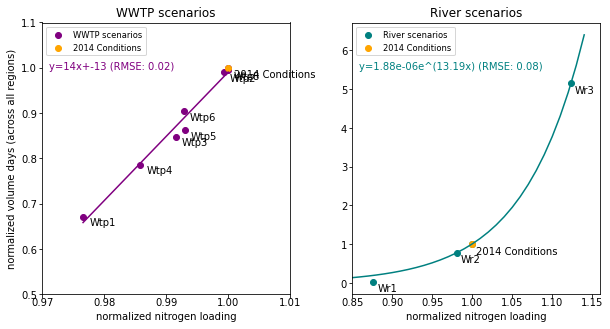

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5),
       gridspec_kw={
           'width_ratios': [1,1],
           'height_ratios': [1],
       'wspace': 0.25,
       'hspace': 0.15})
# plot up wwtp scenarios 
ax[0].scatter(N_plot['wwtp'],vd_plot['wwtp'],color='purple',label='WWTP scenarios')
ax[0].scatter(N_plot['base'],vd_plot['base'],color='orange',label='2014 Conditions')
ax[0].plot(
    np.unique(N_plot['wwtp']), 
    np.poly1d(np.polyfit(N_plot['wwtp'], vd_plot['wwtp'], 1))(np.unique(N_plot['wwtp'])), 
    color='purple'
)
# add text for line fit
fig.text(.135,0.75,f"y={w_poly['wwtp'][1]:2.0f}x+{w_poly['wwtp'][0]:2.0f} (RMSE: {rmse['wwtp']:.2f})",color='purple')
# add run labels to graphic
[ax[0].text(x=N_plot['wwtp'][idx]+.001, y=vd_plot['wwtp'][idx]-.02, s=run_name) for idx,run_name in enumerate(runs_renamed['wwtp'])]
# legends and labels
ax[0].legend(loc='upper left')#bbox_to_anchor=(1,1),loc='upper left')
ax[0].set_xlabel('normalized nitrogen loading')
ax[0].set_xlim(0.97,1.01)
if region != "Whidbey":
    ax[0].set_ylim(0.5,1.1)
ax[0].set_title('WWTP scenarios')
if region == "ALL_REGIONS":
    ax[0].set_ylabel(f'normalized volume days (across all regions)')
else:
    ax[0].set_ylabel(f'normalized volume days ({region.lower()})')
    
# plot river scenarios
ax[1].scatter(N_plot['rivers'],vd_plot['rivers'],color='teal',label='River scenarios')
ax[1].scatter(N_plot['base'],vd_plot['base'],color='orange',label='2014 Conditions')

# Create exponential fit
C = np.polyfit(N_plot['rivers'][[0,2,3]], np.log(vd_plot['rivers'][[0,2,3]]), 1)
xpoints = np.arange(0.85,1.15,0.01)
river_fit = (
    np.exp(C[1])* 
    np.exp(C[0]*xpoints)
)
ax[1].plot(xpoints,river_fit, 
    color='teal'
)
fit_values = np.exp(C[1])*np.exp(C[0]*N_plot['rivers'])
rmse['rivers']=np.sqrt(np.sum((vd_plot['rivers']-fit_values)**2)/len(vd_plot['rivers']))
# add text for line fit
fig.text(.565,0.75,f"y={np.exp(C[1]):.02e}e^({C[0]:.02f}x) (RMSE: {rmse['rivers']:.2f})",color='teal')
# add run labels to graphic
[ax[1].text(x=N_plot['rivers'][idx]+.005, y=vd_plot['rivers'][idx]-.25, s=run_name) for idx,run_name in enumerate(runs_renamed['rivers'])]
#legends and labels
ax[1].legend(loc='upper left')#bbox_to_anchor=(1,1),loc='upper left')
ax[1].set_xlabel('normalized nitrogen loading')
ax[1].set_xlim(0.85, 1.16)
ax[1].set_title('River scenarios')
plt.savefig(f'/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/graphics/line_fits/whidbey_nitrogen_volumedays_fit_{region}_2panel_exp.png', bbox_inches='tight', format='png', dpi=1000)

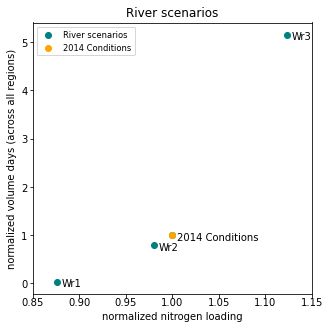

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5),
       gridspec_kw={
           'width_ratios': [1],
           'height_ratios': [1],
       'wspace': 0.25,
       'hspace': 0.15})
ax.scatter(N_plot['rivers'],vd_plot['rivers'],color='teal',label='River scenarios')
#ax.scatter(N_plot['wwtp'],vd_plot['wwtp'],color='purple',label='WWTP scenarios')
ax.scatter(N_plot['base'],vd_plot['base'],color='orange',label='2014 Conditions')
# plt.plot(np.unique(N_plot[rivers_2014]), np.poly1d(np.polyfit(N_plot[rivers_2014], vd_plot[rivers_2014], 1))(np.unique(N_plot[rivers_2014])), color='teal')
# plt.plot(np.unique(N_plot[wwtp_2014]), np.poly1d(np.polyfit(N_plot[wwtp_2014], vd_plot[wwtp_2014], 1))(np.unique(N_plot[wwtp_2014])), color='purple')
# x = np.array([.9,1,1.1])
#plt.plot(x, 14.06516795*x + -13.07638237,'k')
# fig.text(.15,0.825,f"y={w_poly['rivers'][1]:2.1f}x+{w_poly['rivers'][0]:2.1f} (RMSE: {rmse['rivers']:.2f})",color='teal')
# fig.text(.15,0.775,f"y={w_poly['wwtp'][1]:2.1f}x+{w_poly['wwtp'][0]:2.1f} (RMSE: {rmse['wwtp']:.2f})",color='purple')
ax.legend(loc='upper left')#bbox_to_anchor=(1,1),loc='upper left')
ax.set_xlabel('normalized nitrogen loading')
ax.set_xlim(0.85,1.15)
ax.set_title('River scenarios')
# add run labels to graphic
[plt.text(x=N_plot['rivers'][idx]+.005, y=vd_plot['rivers'][idx]-.1, s=run_name) for idx,run_name in enumerate(runs_renamed['rivers'])]
if region == "ALL_REGIONS":
    ax.set_ylabel(f'normalized volume days (across all regions)')
else:
    ax.set_ylabel(f'normalized volume days ({region})')

# My original method below (before adapting Ben's)

In [25]:
loading = {}
for run in runs:
    with open(loading_files[run], 'r') as file:
        print(f'loading {loading_files[run].name}')
        #loading[run]=pandas.read_csv(file,skiprows=261, nrows=258, delimiter=' ')
        loading[run] = pandas.read_csv(file, skiprows=522, delimiter=' ', header=None)#, names=source_names)
        # the row starts with a space so the first column is no-data.  
        # remove the no-data column
        loading[run]=loading[run].drop([0], axis=1)
        # create a dictionary with keys being column names and values being the nutrient loading source name
        name_mapper = {[*loading[run]][i]: source_names[i] for i in range(len([*loading[run]]))}
        # rename columns to source names
        loading[run]=loading[run].rename(columns = name_mapper)

KeyError: 'wqm_baseline'